<a href="https://colab.research.google.com/github/minniens/ADP_Study/blob/main/Chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/TorchMind/car_evaluation.csv'

df = pd.read_csv(path)
df

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


<Axes: ylabel='count'>

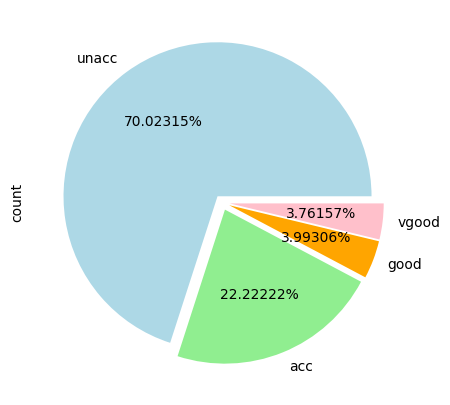

In [ ]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 7
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size
df.output.value_counts().plot(kind='pie', autopct = '%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05,0.05,0.05,0.05))

In [ ]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']
for category in categorical_columns:
  df[category] = df[category].astype('category')

price = df['price'].cat.codes.values
maint = df['maint'].cat.codes.values
doors = df['doors'].cat.codes.values
persons = df['persons'].cat.codes.values
lug_capacity = df['lug_capacity'].cat.codes.values
safety = df['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety],1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [ ]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [ ]:
outputs = pd.get_dummies(df.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()
print(df.output.describe())
print(4*1728)
print(categorical_data.shape)
print(outputs.shape)

count      1728
unique        4
top       unacc
freq       1210
Name: output, dtype: object
6912
torch.Size([1728, 6])
torch.Size([6912])


In [ ]:
categorical_columns_sizes = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [ ]:
total_records = 1728
test_records = int(total_records * 0.2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records -test_records : total_records]

In [ ]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [ ]:
class Model(nn.Module):
  def __init__(self, embedding_size, output_size, layers, p=0.4):
    super().__init__()
    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.embedding_dropout = nn.Dropout(p)

    all_layers = []
    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols

    for i in layers:
      all_layers.append(nn.Linear(input_size, i))
      all_layers.append(nn.ReLU(inplace = True))
      all_layers.append(nn.BatchNorm1d(i))
      all_layers.append(nn.Dropout(p))
      input_size = i

    all_layers.append(nn.Linear(layers[-1], output_size))
    self.layers = nn.Sequential(*all_layers)

  def forward(self, x_categorical):
    embeddings = []
    for i, e in enumerate(self.all_embeddings):
      embeddings.append(e(x_categorical[:,i]))

    x = torch.cat(embeddings,1)
    x = self.embedding_dropout(x)
    x = self.layers(x)

    return x

In [ ]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


In [ ]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
  i += 1
  y_pred = model(categorical_train_data).to(device)
  single_loss = loss_function(y_pred, train_outputs)
  aggregated_losses.append(single_loss)

  if i%25 ==1 :
    print(f'epoch: {i:3} loss : {single_loss.item():10.8f}')

  optimizer.zero_grad()
  single_loss.backward()
  optimizer.step()

print(f'epoch: {i:3} loss : {single_loss.item():10.10f}')

epoch:   1 loss : 1.62255168
epoch:  26 loss : 1.43532073
epoch:  51 loss : 1.33514571
epoch:  76 loss : 1.22226524
epoch: 101 loss : 1.10882461
epoch: 126 loss : 0.93991095
epoch: 151 loss : 0.83196002
epoch: 176 loss : 0.76146215
epoch: 201 loss : 0.68936813
epoch: 226 loss : 0.66893876
epoch: 251 loss : 0.62809062
epoch: 276 loss : 0.61795253
epoch: 301 loss : 0.61001706
epoch: 326 loss : 0.60051870
epoch: 351 loss : 0.59144211
epoch: 376 loss : 0.58727270
epoch: 401 loss : 0.58802110
epoch: 426 loss : 0.57466376
epoch: 451 loss : 0.57885760
epoch: 476 loss : 0.56913507
epoch: 500 loss : 0.5737664104


In [ ]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
  y_val = model(categorical_test_data)
  loss = loss_function(y_val, test_outputs)

print(f'Loss : {loss:.8f}')

Loss : 0.55322021


In [ ]:
print(y_val[:5])

tensor([[ 3.5413,  2.0225, -4.3669, -4.7398],
        [ 3.2686,  1.9653, -4.1754, -4.1823],
        [ 2.4985,  1.6994, -3.2329, -3.3251],
        [ 3.5620,  2.0533, -3.9727, -4.2073],
        [ 2.1251,  1.4796, -2.8704, -3.1333]])


In [ ]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[257   2]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       259
           1       0.00      0.00      0.00        86

    accuracy                           0.74       345
   macro avg       0.37      0.50      0.43       345
weighted avg       0.56      0.74      0.64       345

0.744927536231884
